In [1]:
# # uncomment this to install packages
# import sys
# !{sys.executable} -m pip install <package name>

### Imports

In [2]:
# imports
import numpy as np
from astropy import units as u
from astropy import coordinates as c
import matplotlib.pyplot as plt
from matplotlib import rcParams as P
import astropy.modeling.rotations as r
from scipy.spatial.transform import Rotation as R
import math
import random

In [3]:
# matplotlib.rcParams.keys()

### Helper functions

#### angle generator

In [4]:
def generate_angles():
    # generates the 3 needed euler angles at random
    # angles
    alpha = 2 * np.pi * np.random.random()  #generate random rotation angles
    beta = np.pi * np.random.random()
    gamma = 2 * np.pi * np.random.random()
    
    # alpha, beta, gamma = 0.1, 0, 0
    
    return (alpha, beta, gamma)

#### galaxy rotator

In [5]:
# This function performs an Euler rotation on the data, returns the new glon and glat
# prof. watkins' code (plus some additions of my own)
# uses scipy to preform a random euler rotation  
def rotate(data, angles):
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # data part
    glon = data[: ,10] * np.pi / 180
    glat = data[: ,11] * np.pi / 180

    #make glon and glat into array of positions on the unit sphere
    pos = np.array([np.cos(glon) * np.cos(glat),  # alpha
                np.sin(glon) * np.cos(glat),  # beta
                np.sin(glat)])                # gamma

    pos = np.transpose(pos)

    r = R.from_euler('xzx', [alpha, beta, gamma]) #create the rotation
    posprime = r.apply(pos)  #apply the rotation to the vectors

    glonprime = np.arctan2(posprime[: ,1], posprime[: ,0]) * 180 / np.pi  #convert back to degrees
    glonprime[glonprime < 0] = 360 + glonprime[glonprime < 0]

    glatprime = np.arcsin(posprime[: ,2]) * 180/np.pi
    
    # accounting for zone of avoidance
    indices = np.where(abs(glatprime) > 5)
    glonprime = glonprime[indices]
    glatprime = glatprime[indices]
    
    
    # glonprime, glatprime = c.Angle(glonprime, u.degree), c.Angle(glatprime, u.degree)
    glonprime = c.Angle(glonprime, u.degree)
    glatprime = c.Angle(glatprime, u.degree)
    
    # print(f'{alpha=}, {beta=}, {gamma=}')  # angles of rotation (radians)
    glonprime, glatprime = glonprime.wrap_at('180d', inplace=False).radian, glatprime.radian
    
    return glonprime, glatprime

#### bulkflow rotator

In [6]:
def rotate_bulkflow(bulkflow, angles: tuple, error: float):
    # rotates one bulkflow for ONE catalogue at a time, to be used in a loop in sync with the previous rotate function
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # rotation part
    r = R.from_euler('xzx', [alpha, beta, gamma])
    bulkflowprime = r.apply(bulkflow)
    
    bulkflowprime += bulkflowprime*error
    
    return bulkflowprime  # returns an array of the new components of the new bulkflow

### 'main'
#### Loading, processing, visualizing the data

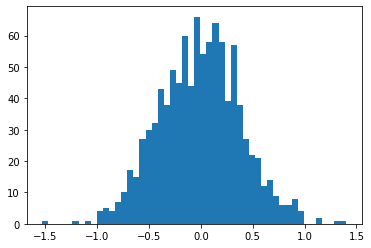

In [7]:
bulkflows = np.load('C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/true_bulkflows100.npy')

# load the data
for i in range(2,3): # use range(300) to run on all catalogues (BAD IDEA)
    data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')
    # glat and glon are in degrees, make unit objects to ease operations
    glon, glat = data[: ,10], data[: ,11]
    glon = c.Angle(glon, u.degree)
    glat = c.Angle(glat, u.degree)
                    
    # changing range of glon to (-180, 180) instead of (0, 360)
    glon = glon.wrap_at('180d', inplace=False)
    
    # Accounting for zone of avoidance (taking out data points with -5 < glat < 5)
    indices = np.where(abs(glat.value) > 5)
    glon = glon[indices]
    glat = glat[indices]

    errors = []

    # generating multiple versions of each catalogue
    for _ in range(1000):
        '''
        generating angles of rotation
        'angles' will be a tuple with 3 elements (alpha, beta, gamma)
        look cell No. 4 (generate angles) for function definition
        '''
        angles = generate_angles()
        
        '''
        generating an error between 0 and 40% on a galcian distribution
        '''
        error = np.random.normal() * 0.4
        errors.append(error)
        # error = 0  # uncomment this to set error to 0
        
        '''
        rotating the bulkflows
        including the error
        'bulkflow' will be a 1x3 array with the xyz components
        of the bulkflow for the respective catalogue
        look cell No. 6 (bulkflow rotator) for function definition
        '''
        bulkflow = bulkflows[:,i]
        bulkflow_prime = rotate_bulkflow(bulkflow, angles, error)
        
        '''
        random euler rotation of the data
        '''
        glonprime, glatprime = rotate(data, angles)
        
        '''
        figure generator
        uncomment the following to generate a figure 
        do NOT uncomment if processing large amounts of data
        trust me you WILL regret it
        '''
        # ------------------------------------------------------
        # # making figure
        # fig = plt.figure(figsize=(20, 20))
        # P.update({'font.size': 18,
        #                    'axes.linewidth': 1.5,
        #                    'axes.labelweight': 'bold',
        #                    })
        
        # # subplot 1
        # ax1 = fig.add_subplot(221, projection='hammer')
        # ax1.scatter(glon.radian, glat.radian, marker='.', linewidths=0.001)
        # ax1.scatter(glonprime, glatprime, marker='.', linewidths=0.001, color='red')
        # ax1.grid(True)
        # ax1.title.set_text(f'No. {i}')
        
        # the angles will be printed
        # print('original bulkflow xyz:\n', bulkflows[:,i])
        # print('rotated bulkflow xyz:\n', bulkflow_prime)
        # print('original bulkflow magnitude:\n', math.sqrt(bulkflows[:,i][0]**2+bulkflows[:,i][1]**2+bulkflows[:,i][2]**2))
        # print(f'rotated bulkflow magnitude (with {error=}):\n', math.sqrt(bulkflow_prime[0]**2+bulkflow_prime[1]**2+bulkflow_prime[2]**2))
        
        # # subplot 2
        # ax2 = fig.add_subplot(222, projection='hammer')
        # ax2.scatter(glonprime, glatprime, marker='.', linewidths=0.001, color='red')
        
        # ax2.grid(True)
        # ax2.title.set_text(f'No. {i}')
        
        # x,y,z = bulkflows[:,i]
        # x1,y1,z1 = bulkflow_prime
        
        # ax = fig.add_subplot(223, projection='3d')
        # ax.plot((0, x) ,(0, y),(0, z))
        # ax.plot((0, x1) ,(0, y1),(0, z1))
        # ax.scatter(x,y,z)
        # ax.scatter(x1,y1,z1)
        # ax.view_init(-155, 45)

        # fig.show()
    plt.hist(errors, bins=50)
    
    

In [8]:
def magnitude(x,y,z):
    return math.sqrt(x**2 + y**2 + z**2)

magnitude(-257.2401123, -26.19958496, -64.7922287)

266.5650512128437